<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/ProcessingTwitters_UEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!wget http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
!tar -xvf dados-curso-completo.csv.tar.gz

--2020-10-07 02:47:22--  http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
Resolving tiagodemelo.info (tiagodemelo.info)... 108.167.188.189
Connecting to tiagodemelo.info (tiagodemelo.info)|108.167.188.189|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143340808 (137M) [application/x-gzip]
Saving to: ‘dados-curso-completo.csv.tar.gz.2’

dados-curso-complet 100%[===================>] 136.70M  51.8MB/s    in 2.6s    

2020-10-07 02:47:25 (51.8 MB/s) - ‘dados-curso-completo.csv.tar.gz.2’ saved [143340808/143340808]

dados-curso-completo.csv


In [25]:
!pip install geopandas

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import nltk
nltk.download('punkt')

from shapely.geometry import Point

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
tweets_df = pd.read_csv('dados-curso-completo.csv')
tweets_df.head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu...,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]


In [28]:
total_records = len(tweets_df.index)
print('Total records:', total_records)

print('Number of records without date:', tweets_df.data.isnull().sum())
print('Number of records without text:', tweets_df.texto.isnull().sum())

no_city_count = tweets_df.lugar.isnull().sum()
no_city_percentage = tweets_df.lugar.isnull().mean() * 100
print('Number of records without city:', no_city_count)
print('Percentage of records without city:', no_city_percentage)

print(tweets_df['pais'].isnull().sum())
print(tweets_df['pais'].isna().sum())
print('lat', tweets_df['latitude'].isna().sum())
print('lat', tweets_df['latitude'].isnull().sum())
print(tweets_df['longitude'].isna().sum())
tweets_df.info()
tweets_df.count()

Total records: 1658825
Number of records without date: 0
Number of records without text: 0
Number of records without city: 1584220
Percentage of records without city: 95.50253944810333
1584225
1584225
lat 1650105
lat 1650105
1650105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658825 entries, 0 to 1658824
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   data        1658825 non-null  object 
 1   usuario     1658768 non-null  object 
 2   apelido     1658825 non-null  object 
 3   texto       1658825 non-null  object 
 4   retweet     1658825 non-null  int64  
 5   seguidores  1658825 non-null  int64  
 6   idioma      1658825 non-null  object 
 7   lugar       74605 non-null    object 
 8   pais        74600 non-null    object 
 9   sigla       74595 non-null    object 
 10  latitude    8720 non-null     float64
 11  longitude   8720 non-null     float64
 12  hashtags    1658825 non-null  object 
dtypes: f

data          1658825
usuario       1658768
apelido       1658825
texto         1658825
retweet       1658825
seguidores    1658825
idioma        1658825
lugar           74605
pais            74600
sigla           74595
latitude         8720
longitude        8720
hashtags      1658825
dtype: int64

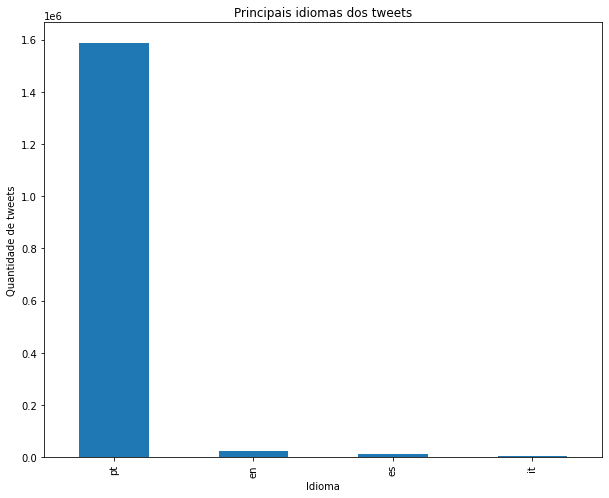

In [29]:
tweets_df.groupby('idioma').idioma.count().sort_values(ascending = False)[:4].plot(kind = 'bar', figsize = (10, 8))
plt.title('Principais idiomas dos tweets')
plt.xlabel('Idioma')
plt.ylabel('Quantidade de tweets')
plt.show()

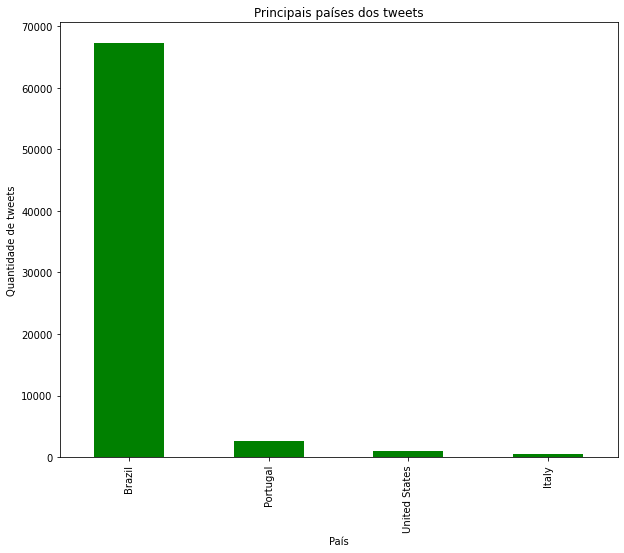

In [30]:
tweets_df.groupby('pais').pais.count().sort_values(ascending = False)[:4].plot(kind = 'bar', figsize = (10, 8), color = 'g')
plt.title('Principais países dos tweets')
plt.xlabel('País')
plt.ylabel('Quantidade de tweets')
plt.show()

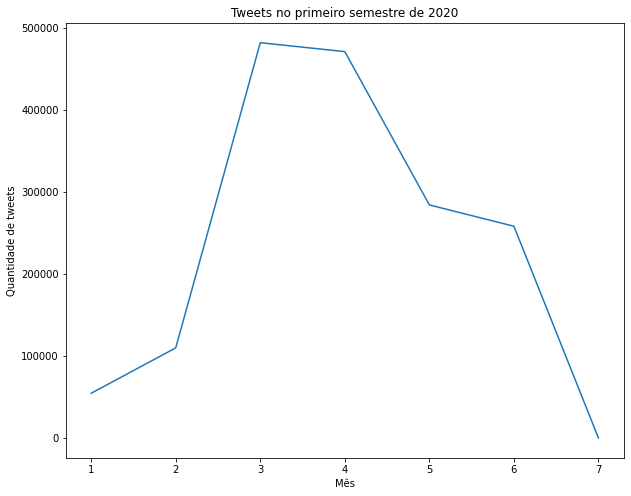

In [31]:
tweets_df.data = tweets_df.data.astype("datetime64")
tweets_df.groupby(tweets_df.data.dt.month).texto.count().plot(kind="line", figsize = (10, 8))
plt.title('Tweets no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de tweets')
plt.show()

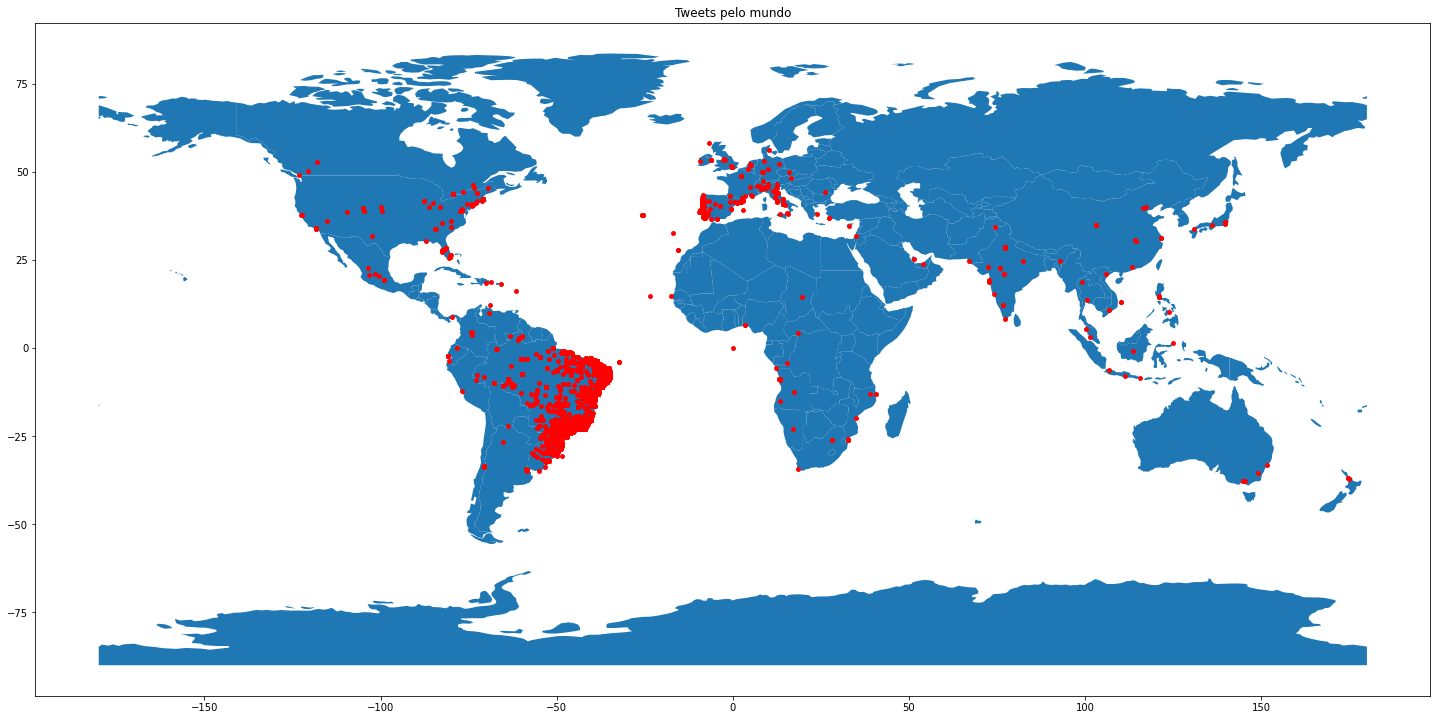

In [32]:
geometry = [Point(xy) for xy in zip(tweets_df.loc[tweets_df.latitude.notnull()].latitude, tweets_df.loc[tweets_df.longitude.notnull()].longitude)]
location_dic = {'tweet': tweets_df.loc[tweets_df.latitude.notnull()].texto, 'geometry': geometry}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=world.plot(figsize=(25, 20)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo mundo')
plt.show()

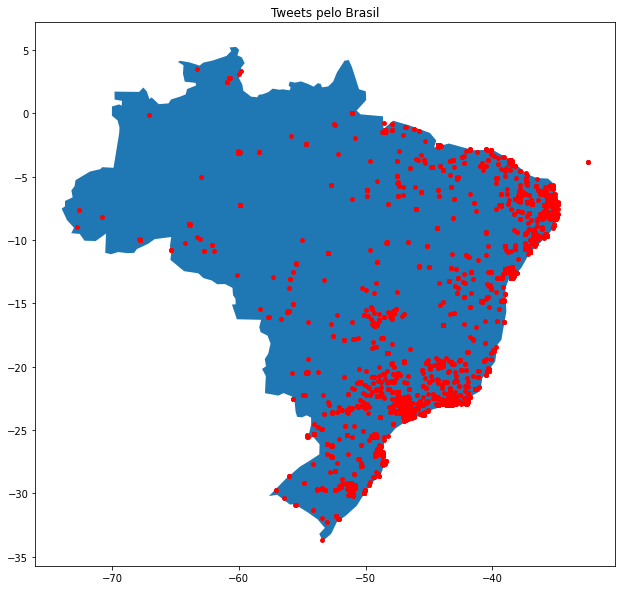

In [33]:
country = 'Brazil'
latitudes = tweets_df.loc[(tweets_df.latitude.notnull()) & (tweets_df.pais == country)].latitude
longitudes = tweets_df.loc[(tweets_df.longitude.notnull()) & (tweets_df.pais == country)].longitude
localized_tweets = tweets_df.loc[(tweets_df.latitude.notnull()) & (tweets_df.pais == country)].texto
geometry = [Point(xy) for xy in zip(latitudes, longitudes)]
location_dic = {'tweet': localized_tweets, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo Brasil')
plt.show()

In [34]:
q2 = tweets_df[tweets_df.texto.str.contains('\?')]
q2

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
38,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,@ipratesMD @dr_pampers Será que corremos o ris...,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
45,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,Prioridade ?!\n\n #COVID19 #floripa #isolament...,0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
57,2020-03-30 00:43:36,Valnei do Val,vdoval,"Que tal uma notícia boa, indo na contramão do ...",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658795,2020-03-24 23:50:14,solineuza da diarista,gtstayhigh,E ai quem são vcs durante a quarentena? \n\nEu...,0,1329,pt,NaN,NaN,NaN,NaN,NaN,[]
1658810,2020-03-26 21:43:24,Chris CP,Chris_CP_,"@0n3p1ece @alexmono Oh jumentinha, 1918 é isso...",0,34,pt,NaN,NaN,NaN,NaN,NaN,[]
1658818,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,@BiologiaBraba @Tati_Cordeiro Só vontade ou vo...,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
1658820,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerado...,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


In [35]:
q2.columns

Index(['data', 'usuario', 'apelido', 'texto', 'retweet', 'seguidores',
       'idioma', 'lugar', 'pais', 'sigla', 'latitude', 'longitude',
       'hashtags'],
      dtype='object')

In [36]:
!pip install wordcloud -q


In [37]:
tweets = q2['texto']

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [39]:
all_tweets= " ".join(s for s in tweets)

In [40]:
stopwords = set(STOPWORDS)

In [41]:
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os","http","https"])

In [42]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black', width=1600,                            
                      height=800).generate(all_tweets)

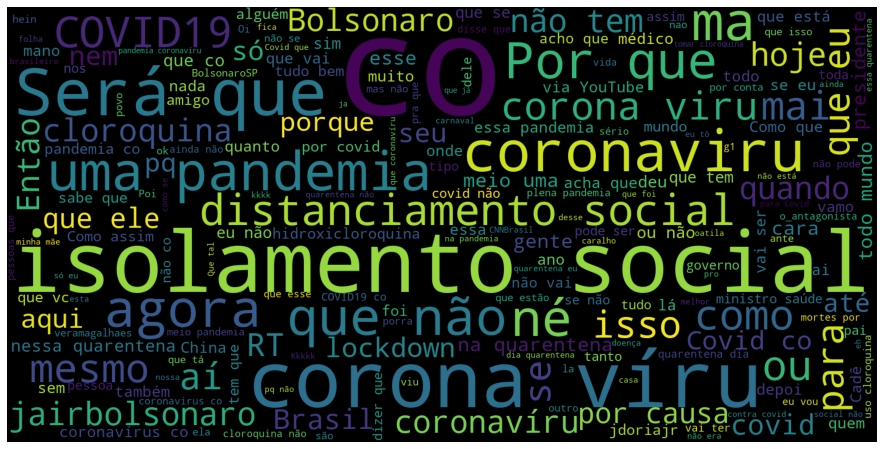

In [43]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)                 


# Perguntas do Twitter

In [53]:
questions_df = tweets_df.loc[tweets_df.texto.str.contains('?', regex=False)]
new_rows = []

for row in questions_df.itertuples():
  sentences = nltk.sent_tokenize(row.texto)

  for sentence in sentences:
    if '?' in sentence:
      new_rows.append((row.data, row.usuario, row.apelido, sentence, row.retweet, row.seguidores, row.idioma, row.lugar, row.pais, row.sigla, row.latitude, row.longitude, row.hashtags))

questions_df = pd.DataFrame(new_rows, columns=tweets_df.columns.array)
questions_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado???,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus?,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,@ipratesMD @dr_pampers Será que corremos o ris...,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,Prioridade ?!,0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
4,2020-03-30 00:43:36,Valnei do Val,vdoval,"Que tal uma notícia boa, indo na contramão do ...",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206550,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Ansiedade?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
206551,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Angústia?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
206552,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Covid?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
206553,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerado...,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


In [45]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206555 entries, 0 to 206554
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   data        206555 non-null  datetime64[ns]
 1   usuario     206548 non-null  object        
 2   apelido     206555 non-null  object        
 3   texto       206555 non-null  object        
 4   retweet     206555 non-null  int64         
 5   seguidores  206555 non-null  int64         
 6   idioma      206555 non-null  object        
 7   lugar       9275 non-null    object        
 8   pais        9275 non-null    object        
 9   sigla       9275 non-null    object        
 10  latitude    661 non-null     float64       
 11  longitude   661 non-null     float64       
 12  hashtags    206555 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 20.5+ MB


# Visão geral dos dados



1. Devem apresentar um resumo (sumário) com as estatísticas dos dados originais, ou seja, sem
qualquer pré-processamento. A apresentação deste tipo de informação relevante para que outras pessoas possam ter uma visão geral dos dados. As estatísticas podem ser apresentadas
através de tabelas e/ou gráficos.

Total de Registros | Total de Twitters | Total de Cidades | Total de HashTags 
--- | --- | --- | ---
Row 1, Col 1 | Row 1, Col 2 | Row 1, Col 3 | Row 1, Col 4


---

Total de Registros Nulos | Total de  | Total de  | Total de  
--- | --- | --- | ---
Row 1, Col 1 | Row 1, Col 2 | Row 1, Col 3 | Row 1, Col 4


---

Inserir Gráfico

2. As mensagens foram pré-processadas para que as perguntas (questões) fossem identificadas.
Essa coleção de perguntas corresponde ao dataset “DuvidasDB”. A seguir, a equipe deve
apresentar as estatísticas sobre esses dados.

Total de Perguntas Selecioandas | Total de  | Total de  
--- | --- | --- 
Row 1, Col 1 | Row 1, Col 2 | Row 1, Col 3

Inserir Gráfico


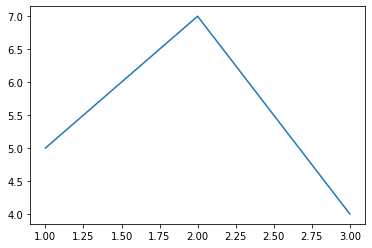

In [46]:
plt.plot([1,2,3],[5,7,4])
plt.show()

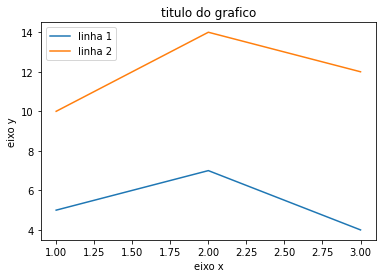

In [47]:
x = [1,2,3]
y = [5,7,4]
x2 = [1,2,3]
y2 = [10,14,12]

plt.plot(x,y,label = 'linha 1')
plt.plot(x2,y2, label = 'linha 2')

plt.xlabel('eixo x')
plt.ylabel('eixo y')

plt.title('titulo do grafico')
plt.legend()

plt.show()

[]

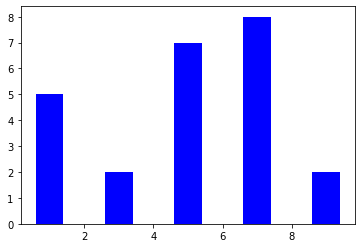

In [48]:
plt.bar([1,3,5,7,9],[5,2,7,8,2],label=' categoria 1', color = 'b')
plt.plot()

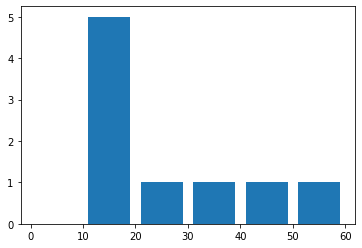

In [49]:
idades = [10,15,14,18,33,43,56,23,12]
div = [0,10,20,30,40,50,60]
plt.hist(idades, div,histtype='bar', rwidth=0.8)
plt.show()

[]

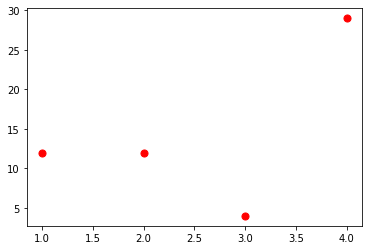

In [50]:
x = [1,2,3,4]
y = [12,12,4,29]

plt.scatter(x,y,label='gols', color='r', s=50, marker = "o")
plt.plot()

# Temas Discutidos

As equipes devem fazer uma análise sobre os temas que são debatidos nas perguntas dos
postadas pelos usuários. Faça uma análise se as perguntas são relativas aos seguintes temas:



1.   Doença. Quando a pergunta é relativa à doença. Deve-se observar que a doença é identificada por vários nomes. Exemplo: coronavírus, corona, COVID-19, etc.
2.   Medicamento. Quando a pergunta é sobre o uso de determinado medicamento no tratamento
da doença.
3.   Organizações. Quando a pergunta é relativa a uma determinada entidade ou organização.
Emissora de TV, Ministério da Saúde ou empresas, são exemplos de organizações.
4.   Pessoas. Quando a pergunta é sobre determinada pessoa. Por exemplo, a pergunta pode
ser sobre a atuação que determinado político ou pessoa famosa teve durante esse período de
pandemia.





In [51]:

d1['texto'] = q2['texto'].str.lower()
print(d1.shape)
d1.groupby(d1.texto.str.contains('coronavirus')).texto.count()

NameError: ignored

# Visão Temporal

Deve-se fazer uma análise temporal das perguntas que formam o dataset DuvidasDB. Pode-se considerar o intervalo temporal de dias, semanas ou meses. A escolha do intervalo de tempo ficará a cargo das equipes. Exemplos de análise temporal: a) houve um aumento no número de perguntas ao longo do tempo? b) houve uma mudança no perfil das perguntas ao longo do tempo?

# Visão Geográfica

Deve-se fazer uma análise geográfica (espacial) das perguntas que formam o dataset DuvidasDB.
Existem algumas colunas no dataset que trazem a informação das localizações como, por exemplo,
o país, estado e cidade. Em alguns tuítes é possível ainda identificar as coordenadas geográficas de latitude e longitude. Exemplo de análise geográfica: a) os usuários de regiões diferentes fazem perguntas com diferentes focos? Por exemplo, será que os usuários de uma região perguntam mais sobre a doença ou sobre o tratamento? Essa análise ainda pode ser realizada em diversos níveis de
área (cidade, estado ou região). Além de apresentar a distribuição das dúvidas dos usuários por região, a equipe deverá fazer uma análise dessa distribuição. Por exemplo, apresentar as razões(ou hipóteses) da ocorrência dessa distribuição.